- data source: https://stockx.com/news/the-2019-data-contest/
- visualization of nike x off-white sneaker resale within 30 days of release

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import requests
from requests.exceptions import HTTPError
import os
import plotly.express as px

In [3]:
sneaker_sales = pd.read_excel('StockX-Data-Contest-2019-3.xlsx', sheet_name='Raw Data')

# time range of sales data
data_start_date = datetime(2017, 9, 1).date()
data_end_date = datetime(2019, 2, 13).date()

# data cleaning
sneaker_sales['Brand'] = sneaker_sales['Brand'].str.strip()
sneaker_sales['Sneaker Name'] = sneaker_sales['Sneaker Name'].str.replace('Adidas', 'adidas') # modified for downloading images
sneaker_sales['Display Sneaker Name'] = sneaker_sales['Sneaker Name'].apply(
    lambda x: x.replace('-', ' ').replace('Off White', 'Off-White').replace('adidas', 'Adidas').replace('2pt0', '2.0')
)
sneaker_sales['Order Date'] = sneaker_sales['Order Date'].dt.date
sneaker_sales['Release Date'] = sneaker_sales['Release Date'].dt.date

In [9]:
sneaker_info = sneaker_sales[['Brand', 'Sneaker Name', 'Display Sneaker Name', 'Release Date', 'Retail Price']]\
    .drop_duplicates()\
    .reset_index(drop=True)
sneaker_info['Release Date + 30 Days'] = sneaker_info['Release Date'] + timedelta(days=30)

# indicates if [release date, release date + 30 days] interval for each sneaker is completely within sales data time range
sneaker_info['Include Sneaker'] = sneaker_info.apply(
    lambda x: True if x['Release Date'] >= data_start_date and x['Release Date + 30 Days'] <= data_end_date else False,
    axis=1
)

sneaker_sales = sneaker_sales.merge(
    sneaker_info[['Sneaker Name', 'Release Date + 30 Days', 'Include Sneaker']],
    how='left',
    on='Sneaker Name'
)
sneaker_sales['Within 30 Days of Release'] = sneaker_sales.apply(
    lambda x: True if x['Release Date'] <= x['Order Date'] <= x['Release Date + 30 Days'] else False,
    axis=1
)

In [10]:
sneaker_sales.head()

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region,Display Sneaker Name,Release Date + 30 Days,Include Sneaker,Within 30 Days of Release
0,2017-09-01,Yeezy,adidas-Yeezy-Boost-350-Low-V2-Beluga,1097.0,220,2016-09-24,11.0,California,Adidas Yeezy Boost 350 Low V2 Beluga,2016-10-24,False,False
1,2017-09-01,Yeezy,adidas-Yeezy-Boost-350-V2-Core-Black-Copper,685.0,220,2016-11-23,11.0,California,Adidas Yeezy Boost 350 V2 Core Black Copper,2016-12-23,False,False
2,2017-09-01,Yeezy,adidas-Yeezy-Boost-350-V2-Core-Black-Green,690.0,220,2016-11-23,11.0,California,Adidas Yeezy Boost 350 V2 Core Black Green,2016-12-23,False,False
3,2017-09-01,Yeezy,adidas-Yeezy-Boost-350-V2-Core-Black-Red,1075.0,220,2016-11-23,11.5,Kentucky,Adidas Yeezy Boost 350 V2 Core Black Red,2016-12-23,False,False
4,2017-09-01,Yeezy,adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,828.0,220,2017-02-11,11.0,Rhode Island,Adidas Yeezy Boost 350 V2 Core Black Red 2017,2017-03-13,False,False


In [34]:
# get stats for each sneaker
sneakers = sneaker_sales[(sneaker_sales['Include Sneaker'] == True) & (sneaker_sales['Within 30 Days of Release'] == True)]\
    .groupby(
        ['Brand', 'Sneaker Name', 'Display Sneaker Name', 'Release Date', 'Release Date + 30 Days', 'Retail Price'],
        dropna=False
    )\
    .apply(lambda x: pd.Series({
        '# of Sales': x.shape[0],
        'Avg Sale Price': round(x['Sale Price'].mean(), 2),
        'Median Sale Price': round(x['Sale Price'].median(), 2),
        'Avg Price Premium': round((x['Sale Price'].sum() - x['Retail Price'].sum()) / x['Retail Price'].sum() * 100, 1)
    }))\
    .reset_index()
sneakers['# of Sales'] = sneakers['# of Sales'].astype(int)

ow_sneakers = sneakers[sneakers['Brand'] == 'Off-White']\
    .sort_values('Avg Price Premium', ascending=False)\
    .reset_index(drop=True)

In [35]:
ow_sneakers.head()

,Brand,Sneaker Name,Display Sneaker Name,Release Date,Release Date + 30 Days,Retail Price,# of Sales,Avg Sale Price,Median Sale Price,Avg Price Premium
0,Off-White,Air-Jordan-1-Retro-High-Off-White-Chicago,Air Jordan 1 Retro High Off-White Chicago,2017-09-09,2017-10-09,190,48,1938.56,1903.5,920.3
1,Off-White,Air-Jordan-1-Retro-High-Off-White-White,Air Jordan 1 Retro High Off-White White,2018-03-03,2018-04-02,190,118,1711.90,1697.0,801.0
2,Off-White,Nike-Air-Presto-Off-White,Nike Air Presto Off-White,2017-09-09,2017-10-09,160,48,1220.65,1220.0,662.9
3,Off-White,Nike-Air-Force-1-Low-Virgil-Abloh-Off-White-AF100,Nike Air Force 1 Low Virgil Abloh Off-White AF100,2017-11-04,2017-12-04,150,18,876.17,865.0,484.1
4,Off-White,Nike-Blazer-Mid-Off-White,Nike Blazer Mid Off-White,2017-09-09,2017-10-09,130,33,698.42,699.0,437.2


In [ ]:
# download sneaker images
for sneaker in ow_sneakers['Sneaker Name'].to_list():
    for i in range(1, 37):
        img_index = str(i).zfill(2)
        
        try:
            url = f'https://images.stockx.com/360/{sneaker}/Images/{sneaker}/Lv2/img{img_index}.jpg'
            response = requests.get(url)
            response.raise_for_status()
        except HTTPError as http_error:
            print(f'({sneaker} {img_index}) http error occurred: {http_error}')
        else:
            with open(f'images/{sneaker}_{img_index}.jpg', 'wb') as f:
                f.write(response.content)

In [39]:
images = pd.DataFrame(os.listdir('images'), columns=['filename'])
images['sneaker'] = images['filename'].apply(lambda x: x.split('_')[0])
images['index'] = images['filename'].apply(lambda x: x.split('_')[1].split('.')[0])
images.head()

,filename,sneaker,index
0,Nike-Air-Force-1-Low-Off-White-Black-White_13.jpg,Nike-Air-Force-1-Low-Off-White-Black-White,13
1,Nike-Air-Max-97-Off-White-Black_23.jpg,Nike-Air-Max-97-Off-White-Black,23
2,Nike-Air-Force-1-Low-Off-White-Black-White_07.jpg,Nike-Air-Force-1-Low-Off-White-Black-White,07
3,Nike-Air-VaporMax-Off-White-2018_28.jpg,Nike-Air-VaporMax-Off-White-2018,28
4,Nike-Blazer-Mid-Off-White-All-Hallows-Eve_13.jpg,Nike-Blazer-Mid-Off-White-All-Hallows-Eve,13


In [47]:
images.shape

(894, 3)

In [48]:
# sneaker with no images
set(ow_sneakers['Sneaker Name']).difference(set(images['sneaker']))

{'Nike-Air-Force-1-Low-Virgil-Abloh-Off-White-AF100'}

In [49]:
# sneaker that doesn't have 36 images
images.groupby('sneaker').size()[lambda x: x != 36]

sneaker
Nike-Zoom-Fly-Off-White    30
dtype: int64

In [50]:
ow_sneakers = ow_sneakers[~ow_sneakers['Sneaker Name'].isin(
    [
        'Nike-Air-Force-1-Low-Virgil-Abloh-Off-White-AF100',
        'Nike-Zoom-Fly-Off-White'
    ]
)].reset_index(drop=True)

ow_sneakers.shape

(24, 10)

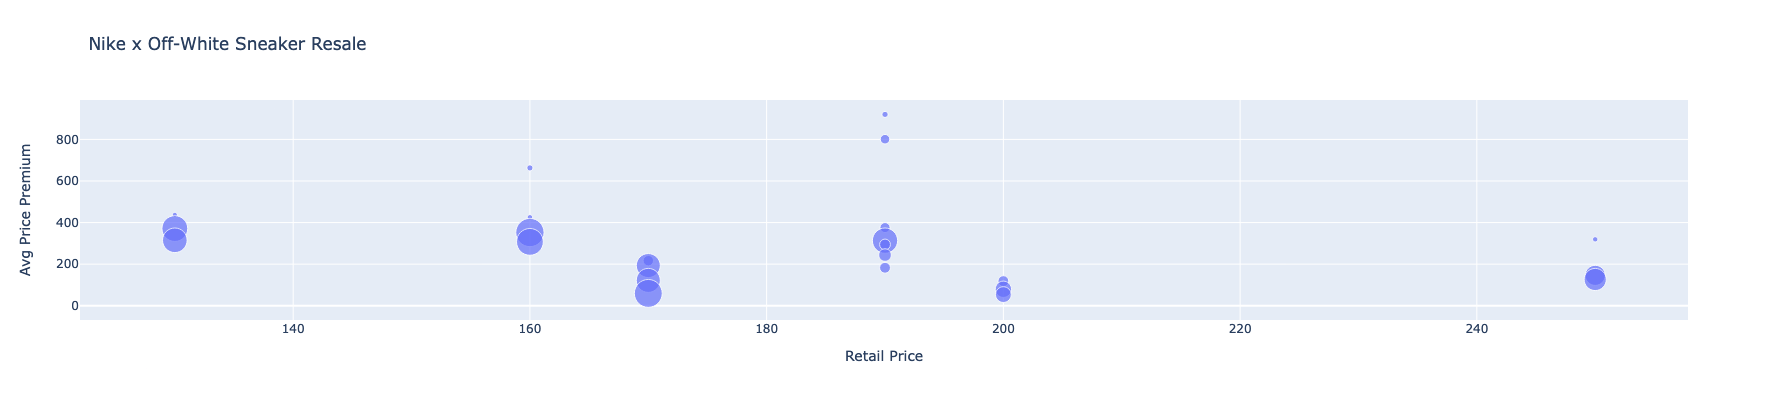

In [68]:
px.scatter(
    ow_sneakers,
    x='Retail Price',
    y='Avg Price Premium',
    size='# of Sales',
    title='Nike x Off-White Sneaker Resale',
    height=400,
    width=700
)

In [69]:
ow_sneakers.reindex([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 18, 19, 20, 21, 22, 23, 14, 17])\
    .to_csv('off-white resale data.csv', index=False)